In [243]:
import os

import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.datasets import make_swiss_roll

from models import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Swiss roll dataset

We will start experimenting with a simple distribution, as it is the swiss roll distribution. We will be based on the Sohl Dickstein (https://arxiv.org/abs/1503.03585) and Jonathan Ho (https://arxiv.org/abs/2006.11239) papers

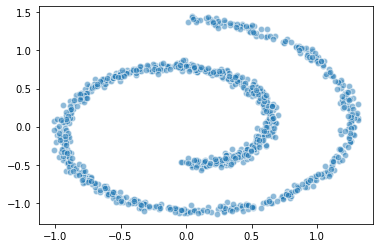

In [244]:
def make_dataset(n_samples=1000, noise=0.3):
    """
    Returns a normalized swiss roll dataset in a (n_samples, 2) matrix, where
    each rows corresponds to a single sample, and each column to a component (x or y).
    """
    points = make_swiss_roll(n_samples=n_samples, noise=noise)[0][:, [0,2]]
    # Normalize the data so it lies between [-1 and 1]
    #max_value = np.max(points)
    max_value = 10.0
    return points/max_value

points = make_dataset(n_samples=1000)
plt.scatter(points[:, 0], points[:, 1], alpha=0.5, color='C0', edgecolor='white', s=40);
plt.show()

### Forward diffusion process

A Gaussian kernel is applied at every step. Given that T is sufficiently large and $\beta$ is considerably small, the final distribution will be a well behaved isotropic gaussian.

$$q(x^{(t)}|x^{(t-1)}) = \mathcal{N}\left(x^{(t)}; \sqrt{1 - \beta_t}x^{(t-1)}, \mathbb{I}\beta_t\right)$$

In the Ho et al. (2021) paper, they use $T=1000$, and the variances are scheduled to increase linearly from $\beta_1 = 10^{-4}$ to $\beta_T = 0.02$.
To obtain $x_t$, we could iteratively apply $q(x_t \mid x_{t-1})$, or we can use the following expression to compute it directly:

$$q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha} _t} x_0, (1 - \bar{\alpha} _t) \mathbb{I})$$

where $\alpha _t = 1 - \beta _t$ and $\bar{\alpha} _t = \prod _{s=1}^t \alpha _s$. It can also be written as:

$$x_t = \sqrt{\bar{\alpha} _t} x_0 + \sqrt{1 - \bar{\alpha} _t}z, \qquad z \sim \mathcal{N}(0, \mathbb{I})$$

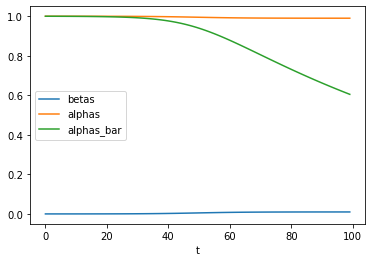

In [245]:
timesteps = 100
#model = SwissRollModel(timesteps=timesteps)
model = ConditionalModel(n_steps=timesteps)
diffusion = Diffusion(model, timesteps=100, beta_1=1e-5, beta_T=1e-2)
betas, alphas, alphas_bar = diffusion.betas, diffusion.alphas, diffusion.alphas_cumprod
plt.plot(betas, label='betas')
plt.plot(alphas, label='alphas')
plt.plot(alphas_bar, label='alphas_bar')
plt.xlabel("t")
plt.legend()
plt.show()

As we can see, when increasing $t$, $x_t$ will be closer to a Gaussian distribution of mean 0 and variance 1, as $\bar{ \alpha} _t$ smoothly goes to zero.

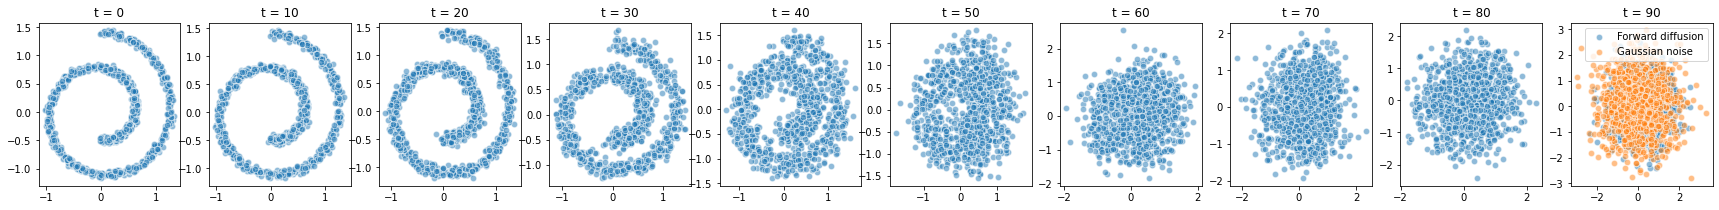

In [246]:
X_0 = torch.tensor(make_dataset())

ts = np.linspace(0, diffusion.timesteps, 10, dtype='int64', endpoint=False)

fig, axes = plt.subplots(ncols=len(ts), figsize=(len(ts)*3, 3))

for t, ax in zip(ts, axes.flat):
    X_t = diffusion.sample_q(X_0, torch.tensor([t]))
    ax.set_title("t = " + str(t))
    ax.scatter(X_t[:, 0], X_t[:, 1], alpha=0.5, color='C0', edgecolor='white', 
               s=40, label="Forward diffusion")
# Sample pure gaussian noise in order to compare
gaussian = np.random.normal(size=(1000, 2))
axes[-1].scatter(gaussian[:, 0], gaussian[:, 1], alpha=0.5, color='C1', 
                 edgecolor='white', s=40, label='Gaussian noise')
plt.legend()
plt.show()

We can also start with a single point and watch how it slowly falls into a Gaussian distribution, i.e. it starts in (0, 1.5) and progressively goes to $\mathcal{N}(0, 1)$

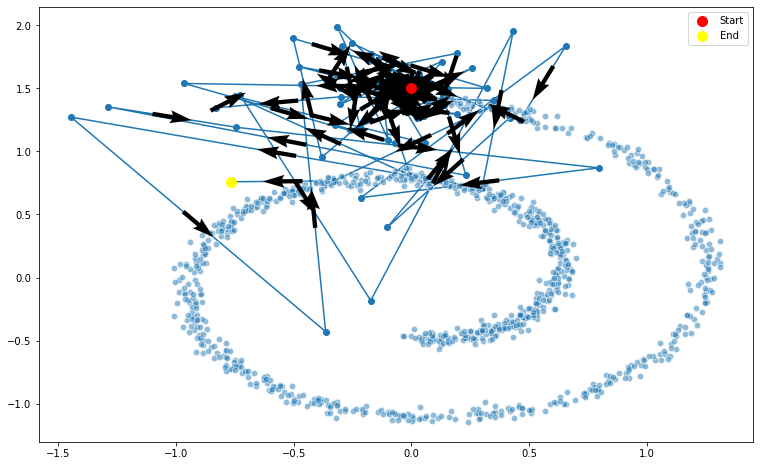

In [247]:
ts = torch.arange(0, 100, 1)
x_0 = torch.tensor([[0., 1.5]]*len(ts))
x_t = diffusion.sample_q(x_0, ts)
ax = plot_trajectory(x_t[:, 0], x_t[:, 1])
ax.scatter(points[:, 0], points[:, 1], alpha=0.5, color='C0', edgecolor='white', s=40)
plt.show()

### Reverse diffusion process

We have trained a model that predicts que noise for the sample $x_t$ at timestep $t$ (see `train_swissroll.py`). Now, we will use it to perform the reverse process and recover the original distribution.

In [248]:
timesteps = 100
#model = SwissRollModel(timesteps=timesteps)
model = ConditionalModel(n_steps=timesteps)
diffusion = Diffusion(model, timesteps=timesteps, beta_1=1e-5, beta_T=1e-2)
diffusion.load_state_dict(torch.load(os.path.join("saved_models", "test.pth")))

<All keys matched successfully>

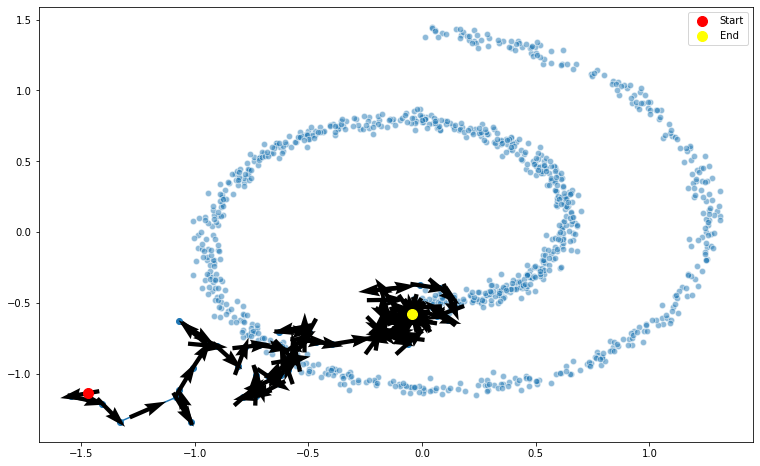

In [263]:
trajectory = torch.squeeze(diffusion.generate(n_samples=1, return_all=True)).detach().numpy()

ax = plot_trajectory(trajectory[:, 0], trajectory[:, 1])
ax.scatter(points[:, 0], points[:, 1], alpha=0.5, color='C0', edgecolor='white', s=40);
plt.show()

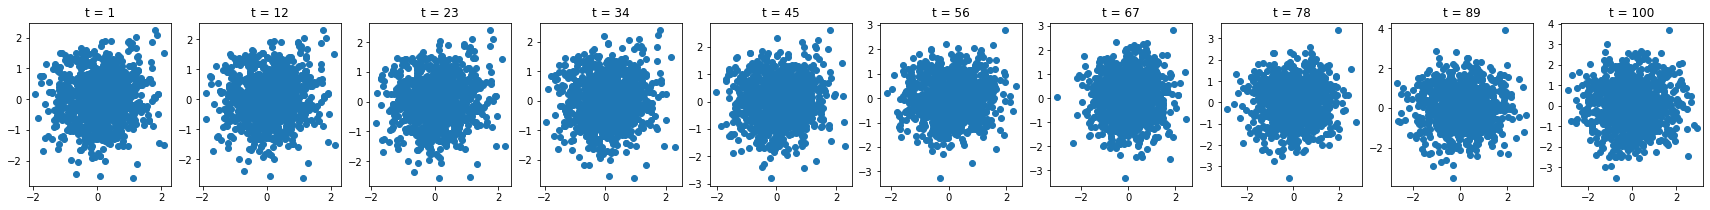

In [250]:
fig = diffusion.plot_reverse_process()
plt.show()